<a href="https://colab.research.google.com/github/a9e68ce5/Machine-Learning/blob/main/Embedding%20for%20image%20clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Module

In [ ]:
import csv
import time
import sys
import os
import random


# other library
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision import transforms

# PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms.functional as fn
from torch.utils import data
from tqdm.notebook import tqdm #美化進度條

# Fix random seed

In [ ]:
SEED = 5566 # Do not modify
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Dataset Download:

In [ ]:
!gdown --id "1Ei-z7wuOosboqxlJj0V99XXyhNlc-eDs" --output "trainX.npy"
!gdown --id "11DCdXZkJqMgMZaPhgwU8WCJ_HCRW5LBw" --output "visualization_X.npy"


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Ei-z7wuOosboqxlJj0V99XXyhNlc-eDs
To: /content/trainX.npy
100% 221M/221M [00:01<00:00, 161MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=11DCdXZkJqMgMZaPhgwU8WCJ_HCRW5LBw
To: /content/visualization_X.npy
100% 15.4M/15.4M [00:00<00:00, 82.8MB/s]


# Set Hyper-parameters

In [ ]:
#TODO: Modified the hyper-parameter
NUM_EPOCH = 20
BATCH_SIZE = 32
LATENT_DIM = 256 #256
REDUCED_DIM = 8 #8
NUM_ITER = 1000
REDUCED_METHOD = 'pca' # or 'tsne''pca'
lr = 5e-4
N=256

In [ ]:
MODEL_NAME = 'model.pth'
DATA_PATH = 'trainX.npy'
VISUAL  ='visualization_X.npy'

# Define Dataset

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, data_path):
        self.total_img = torch.from_numpy(np.load(data_path)).float()
        self.total_img = self.total_img.permute(0, 3, 1, 2)
        self.total_img = self.total_img/255

    def normalize(self, img):
        # TODO: normalize0 the dataset
        mean=img.mean()
        std=img.std()
        img=fn.normalize(img,mean=mean,std=std)
        return img

    def augment(self, img):
        # TODO: do augmentation while loading image
        #img=transform(img)
        return img

    def __len__(self):
        return len(self.total_img)

    def __getitem__(self, index):
        img = self.total_img[index]
        img_aug = self.augment(img)

        img_aug = self.normalize(img_aug)
        img = self.normalize(img)
        return img_aug, img

# ***image augumentation***

In [ ]:
#transform = transforms.Compose([
                 #transforms.ToPILImage(mode=None),#轉成PIL才可以做augumentation
                 #transforms.RandomAdjustSharpness(sharpness_factor=2),
                 #transforms.CenterCrop(32),
                 #transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),#Blurs image with randomly chosen Gaussian blur 用它來減少圖像雜訊以及降低細節層次

                 #transforms.RandomHorizontalFlip(p=0.6),
                 #transforms.RandomPosterize(bits=2),

                 #transforms.ToTensor()#轉成PIL之後一定要轉回tensor才可以讀
                 #]
                 #)#TrivialAugmentWide()AugMix()RandomVerticalFlip(p=0.7)TrivialAugmentWide()RandomPerspective(distortion_scale=0.4, p=0.5)transforms.RandomInvert(p=0.5),
                 #transforms.RandomEqualize(p=0.5),

# Define Model Architerchure

**Please finish this block to run this code!**


In [ ]:
class Net(nn.Module):
    def __init__(self, image_channels=3, latent_dim=256):
        super(Net, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 32

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=3,stride=2,padding=1),
            #nn.ReLU(True),
            nn.ELU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2,padding=1),
            #nn.ReLU(True),
            nn.ELU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(64 , 128, kernel_size=3, stride=2,padding=1),
            #nn.ReLU(True),
            nn.Tanh(),

            nn.Conv2d(128 ,256, kernel_size=3, stride=2,padding=1),
            #nn.ReLU(True),
            nn.Tanh(),




            # TODO: define your own structure
        )

        # TODO: check the dimension if you modified the structure
        self.fc1 = nn.Linear(N , self.latent_dim)

        # TODO: check the dimension if you modified the structure
        self.fc2 = nn.Linear(self.latent_dim, N)


        self.decoder = nn.Sequential(
           # TODO: define yout own structure
           # Hint: nn.ConvTranspose2d(...)

           nn.ConvTranspose2d(256,128,4,stride=2),
           #nn.ReLU(True),
           nn.ELU(True),

           nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),#要做output_padding否則輸入與輸出大小會不一樣
           #nn.ReLU(True),
           nn.ELU(True),

           nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1),
           #nn.ReLU(True),
           nn.Tanh(),

           nn.ConvTranspose2d(32,3,3,stride=2,padding=1,output_padding=1),
           #nn.ReLU(True),
           nn.Tanh(),


        )

    def forward(self, x):
        #print(x.shape)
        feature_map = self.encoder(x)
        #print("feature_map",feature_map.shape)#encoder (batch,channel,height,width)

        latent_vec = self.fc1(feature_map.reshape(feature_map.shape[0], -1))
        #print("latent_vec",latent_vec.shape)#fc1

        feature_map2 = self.fc2(latent_vec)
        #print("feature_map2",feature_map2.shape)#fc2
        feature_map2=feature_map2.view(-1,N,1,1)

        x_res = self.decoder(feature_map2)#decoder
        #print("x_res",x_res.shape)

        return latent_vec, x_res

# Define Training Process

In [ ]:
def training(train, val, model, device, n_epoch, batch, save_name, lr):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('=== start training, parameter total:%d, trainable:%d' % (total, trainable))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=1e-5)
    best_loss = 100
    for epoch in range(n_epoch):
        total_loss = 0

        # training set
        model.train()
        idx = 0
        for image_aug, image in tqdm(train):
            image = image.to(device, dtype=torch.float)
            image_aug = image_aug.to(device, dtype=torch.float)
            _, reconsturct = model(image_aug)
            loss = criterion(reconsturct, image)#nn.MSELoss()

            optimizer.zero_grad()#清空过往梯度
            loss.backward()#反向传播，计算当前梯度；
            optimizer.step()#根据梯度更新网络参数
            total_loss += (loss.item() / len(train))

            print('[Epoch %d | %d/%d] loss: %.4f' %
                 ((epoch+1), idx*batch, len(train)*batch, loss.item()), end='\r')
            idx += 1
        print("\n  Training  | Loss:%.4f " % total_loss)

        # validation set
        model.eval()
        total_loss = 0
        idx = 0
        with torch.no_grad():
            for image_aug, image in tqdm(val):
                image = image.to(device, dtype=torch.float)
                image_aug = image_aug.to(device, dtype=torch.float)
                _, reconstruct = model(image_aug)

                loss = criterion(reconstruct, image)
                total_loss += (loss.item() / len(val))
                idx += 1
            print(" Validation | Loss:%.4f " % total_loss)
        # save model
        if total_loss < best_loss:
                best_loss = total_loss
                print("saving model with loss %.4f...\n" % total_loss)
                torch.save(model.state_dict(), "%s" % save_name)

# Define Clustering Process

In [ ]:
def clustering(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]

    model.eval()
    latent_vec = torch.tensor([]).to(device, dtype=torch.float)
    for idx, (image_aug, image) in enumerate(loader):#enumerate:可以將遍歷的陣列轉成索引列表
        print("predict %d / %d" % (idx, len(loader)) , end='\r')
        image = image.to(device, dtype=torch.float)
        latent, r = model(image)
        latent_vec = torch.cat((latent_vec, latent), dim=0)

    latent_vec = latent_vec.cpu().detach().numpy()

    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1,  method='exact' ,perplexity=perplexity, n_iter=n_iter)
        latent_vec = tsne.fit_transform(latent_vec)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vec = pca.fit_transform(latent_vec)

    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=n_iter).fit(latent_vec)
    return  kmeans.labels_

# Define write function

In [ ]:
def write_output(predict_result, file_name='predict.csv'):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

# Main Process

In [ ]:
# build dataset
dataset = Dataset(DATA_PATH)
print(len(dataset))

# Random split
train_set_size = int(len(dataset) * 0.85)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = data.random_split(dataset, [train_set_size, valid_set_size])

# set data loader
train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
valid_loader = data.DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

model = Net(latent_dim=LATENT_DIM).to(device)
print(model)
training(train_loader, valid_loader, model, device, NUM_EPOCH, BATCH_SIZE, MODEL_NAME, lr)



9000
Net(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ELU(alpha=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ELU(alpha=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): Tanh()
  )
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): ELU(alpha=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ELU(alpha=True)
    (4): ConvTranspose2d(64, 32,

  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 1 | 7648/7680] loss: 0.4055
  Training  | Loss:0.6630 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.5558 
saving model with loss 0.5558...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 2 | 7648/7680] loss: 0.5566
  Training  | Loss:0.5119 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.5083 
saving model with loss 0.5083...



  0%|          | 0/240 [00:00<?, ?it/s]


  Training  | Loss:0.4825 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4845 
saving model with loss 0.4845...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 4 | 7648/7680] loss: 0.3685
  Training  | Loss:0.4608 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4630 
saving model with loss 0.4630...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 5 | 7648/7680] loss: 0.6536
  Training  | Loss:0.4498 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4533 
saving model with loss 0.4533...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 6 | 7648/7680] loss: 0.4896
  Training  | Loss:0.4366 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4389 
saving model with loss 0.4389...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 7 | 7648/7680] loss: 0.5520
  Training  | Loss:0.4236 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4304 
saving model with loss 0.4304...



  0%|          | 0/240 [00:00<?, ?it/s]


  Training  | Loss:0.4154 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4208 
saving model with loss 0.4208...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 9 | 7648/7680] loss: 0.6237
  Training  | Loss:0.4093 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4174 
saving model with loss 0.4174...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 10 | 7648/7680] loss: 0.5678
  Training  | Loss:0.4023 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4085 
saving model with loss 0.4085...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 11 | 7648/7680] loss: 0.5734
  Training  | Loss:0.3949 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4041 
saving model with loss 0.4041...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 12 | 7648/7680] loss: 0.2757
  Training  | Loss:0.3892 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.4002 
saving model with loss 0.4002...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 13 | 7648/7680] loss: 0.5198
  Training  | Loss:0.3862 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3955 
saving model with loss 0.3955...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 14 | 7648/7680] loss: 0.4272
  Training  | Loss:0.3803 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3936 
saving model with loss 0.3936...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 15 | 7648/7680] loss: 0.4603
  Training  | Loss:0.3782 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3924 
saving model with loss 0.3924...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 16 | 7648/7680] loss: 0.1888
  Training  | Loss:0.3741 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3884 
saving model with loss 0.3884...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 17 | 7648/7680] loss: 0.2809
  Training  | Loss:0.3711 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3881 
saving model with loss 0.3881...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 18 | 7648/7680] loss: 0.4425
  Training  | Loss:0.3688 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3839 
saving model with loss 0.3839...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 19 | 7648/7680] loss: 0.5403
  Training  | Loss:0.3673 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3831 
saving model with loss 0.3831...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 20 | 7648/7680] loss: 0.3600
  Training  | Loss:0.3643 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3792 
saving model with loss 0.3792...



# Inference

In [ ]:
test_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
model.load_state_dict(torch.load(MODEL_NAME))
predicted = clustering(model, device, test_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=REDUCED_DIM, perplexity=15)
write_output(predicted, 'pred.csv')

# ***ACC太低再用***

In [ ]:
d=pd.read_csv('pred.csv')
for i in range (len(d)):
 if(d['label'][i]==0):
   d['label'][i]=1
 elif(d.loc[i,'label']==1):
   d.loc[i,'label']=0

d.to_csv('pred2.csv',index=0)

# ***Problem3-PCA與t-sne比較***

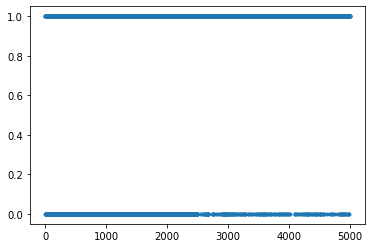

In [ ]:
import matplotlib.pyplot as plt
vis_dataset=Dataset(VISUAL)
visual_loader=data.DataLoader(vis_dataset, batch_size=BATCH_SIZE, shuffle=False)
latent_vec = clustering(model, device, visual_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=REDUCED_DIM, perplexity=15)
import pandas

#df = pandas.DataFrame(dict(Feature_1=latent_vec[:,0], Feature_2=latent_vec[:,1]))

#df.plot(x="Feature_1", y="Feature_2", kind='scatter', colormap='viridis')
#plt.scatter(latent_vec[:,0],latent_vec[:,1])
plt.plot(latent_vec,'.')
#latent_vec

# ***Problem2***

In [ ]:
criterion = nn.MSELoss()
def reconstruct(model , device , loader):
  model.eval()

  latent_vec = torch.tensor([]).to(device, dtype=torch.float)
  for idx, (image_aug, image) in enumerate(loader):
    _, r = model(image)
    loss = criterion(r, image)
    print(loss.item())
    r = r.cpu().detach().numpy()
    for j in range(2):
      temp=r[j]

      temp=torch.tensor(temp)
      temp=temp.permute(2,1,0)
      temp=np.asarray(temp)
      plt.subplot(1,2,j+1,xticks=[],yticks=[])
      plt.imshow((temp))


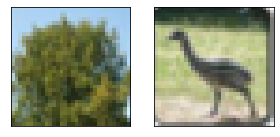

In [ ]:
plt.figure(figsize=(15,15))
indexes = [1,2]
trainX = np.load('trainX.npy')
#type(trainX)
imgs = trainX[indexes,]
#type(imgs)
imgs = imgs/255
for i, img in enumerate(imgs):
    plt.subplot(2, 6, i+1, xticks=[], yticks=[])
    plt.imshow(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.3820466995239258
0.3618859350681305
0.3239050805568695
0.3532237112522125


0.32382795214653015
0.34371939301490784
0.3678413927555084
0.36204028129577637
0.40453436970710754


0.3516566753387451
0.34755638241767883
0.31678539514541626
0.3508807420730591
0.36594533920288086


0.4331001937389374
0.3579365909099579
0.41707947850227356
0.37197986245155334
0.3800562620162964


0.3868426978588104
0.37912335991859436
0.3823847770690918
0.3460543155670166
0.34780243039131165


0.3910895884037018
0.35601985454559326
0.374647855758667
0.36189794540405273
0.3278844654560089


0.33708980679512024
0.363671213388443
0.3638557195663452
0.40672552585601807
0.34919342398643494


0.3836272060871124
0.361898273229599
0.3380225598812103
0.3568427860736847
0.3537282645702362


0.35966598987579346
0.33011189103126526
0.36347243189811707
0.3969741761684418
0.34718117117881775


0.3619552552700043
0.3747495710849762
0.3674701750278473
0.36990436911582947
0.37619733810424805


0.3523000478744507
0.3631666600704193
0.3758446276187897
0.361208438873291
0.34515509009361267


0.37368646264076233
0.37867507338523865
0.37404799461364746
0.37046054005622864
0.3768031895160675


0.34071460366249084
0.3643464148044586
0.3584355413913727
0.3726896345615387
0.3371697962284088


0.33512863516807556
0.34262362122535706
0.3807004392147064
0.3233431279659271
0.36790338158607483


0.40640100836753845
0.3750603199005127
0.41325700283050537
0.33663609623908997
0.3590257167816162


0.3147262930870056
0.3416338264942169
0.3484605848789215
0.37747350335121155
0.399634450674057


0.3511179983615875
0.35823845863342285
0.37948155403137207
0.38848939538002014
0.3281344473361969


0.35899031162261963
0.35431671142578125
0.32646888494491577
0.34575966000556946
0.32912543416023254


0.2979089915752411
0.3332994878292084
0.3486963212490082
0.32711663842201233
0.41677477955818176


0.38697758316993713
0.35863205790519714
0.34984883666038513
0.3648184835910797
0.3940136432647705


0.3582833707332611
0.3091813027858734
0.40590834617614746
0.3528273105621338
0.2988020181655884


0.3967283070087433
0.3657500445842743
0.3614986836910248
0.34435001015663147
0.3456179201602936


0.3444838225841522
0.3998882472515106
0.372056245803833
0.3499767482280731
0.3855195939540863


0.43225565552711487
0.37183889746665955
0.40978434681892395
0.4152637720108032
0.41470322012901306


0.36717745661735535
0.3956768810749054
0.3648873269557953
0.38598623871803284
0.3278167247772217


0.38532593846321106
0.34791693091392517
0.33934828639030457
0.34885168075561523
0.33532479405403137


0.38855528831481934
0.37777313590049744
0.3600653409957886
0.41645345091819763
0.3570769727230072


0.3119550347328186
0.333688348531723
0.3703180253505707
0.39756011962890625
0.3324469327926636


0.41683080792427063
0.37798190116882324
0.33610430359840393
0.32867762446403503
0.37118592858314514


0.35549816489219666
0.3819218575954437
0.35933828353881836
0.3669905364513397
0.33761975169181824


0.38106879591941833
0.3526550233364105
0.34103772044181824
0.3691348135471344
0.3814898431301117


0.3610505163669586
0.3569320738315582
0.3435671329498291
0.3461548089981079
0.3689838647842407


0.3725265562534332
0.3864108622074127
0.41460904479026794
0.4046643078327179
0.38891783356666565


0.3228425979614258
0.3516279458999634
0.3217267096042633
0.3851909339427948
0.341351717710495


0.3601265847682953
0.37938567996025085
0.38994359970092773
0.3006121814250946
0.35641542077064514


0.3476041257381439
0.3673144578933716
0.32679033279418945
0.4093744456768036
0.37892869114875793


0.3618083894252777
0.3245486319065094
0.34807348251342773
0.3245036005973816
0.3307971656322479


0.386482834815979
0.3441223204135895
0.34463170170783997
0.3618271052837372
0.3317563831806183


0.3095567524433136
0.35005441308021545
0.3600074350833893
0.35294270515441895
0.3245161473751068


0.31744059920310974
0.39976966381073
0.3720687925815582
0.38868722319602966
0.37627896666526794


0.3891657292842865
0.3523177206516266
0.38726291060447693
0.36879226565361023
0.37540996074676514


0.336566299200058
0.39517173171043396
0.3553905487060547
0.3724660873413086


0.3834875822067261
0.3228268325328827
0.4063817262649536
0.3699685037136078
0.37077248096466064


0.39107659459114075
0.4073808193206787
0.3965745270252228
0.3615286648273468
0.37482091784477234


0.3477729260921478
0.3441779613494873
0.3173082768917084
0.35338321328163147
0.3726153075695038


0.38185644149780273
0.40028882026672363
0.3291676342487335
0.37964141368865967
0.35645127296447754


0.38472089171409607
0.3604682385921478
0.3859470784664154
0.37123748660087585
0.3685448169708252


0.3563343286514282
0.4042469263076782
0.39430704712867737
0.38993963599205017
0.396492600440979


0.37909460067749023
0.3001398742198944
0.366434782743454
0.3714631497859955
0.3331472873687744


0.3366236984729767
0.34510859847068787
0.3553336560726166
0.3621490001678467
0.3614759147167206


0.37059497833251953
0.343447208404541
0.31493160128593445
0.33894726634025574
0.33366310596466064


0.4348691403865814
0.3375025987625122
0.32428112626075745
0.3884560167789459
0.3559447228908539


0.3707819879055023
0.3787296712398529
0.3717183768749237
0.3512686789035797
0.3873562812805176


0.3825562298297882
0.3757493793964386


0.3573931157588959
0.41777682304382324
0.35448482632637024
0.34155309200286865
0.38952696323394775


0.32781633734703064
0.3579118549823761
0.3622313439846039
0.3718264400959015
0.4046536386013031


0.38561055064201355
0.3472285568714142
0.38093698024749756
0.3344041109085083
0.3744172751903534


0.3443707227706909
0.39704838395118713


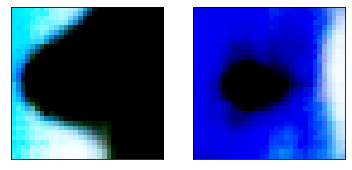

In [ ]:
d=Dataset(DATA_PATH)
test_loader=data.DataLoader(d,batch_size=BATCH_SIZE,shuffle=False)
model=Net(latent_dim=LATENT_DIM).to(device)
model.load_state_dict(torch.load(MODEL_NAME))
reconstruct(model,device,test_loader)



# ***model path***

In [ ]:
!gdown --id "14r7w5jqH6PTvHHd4qC4-BnxwMQNkQQsB" --output "model.pth"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14r7w5jqH6PTvHHd4qC4-BnxwMQNkQQsB
To: /content/model.pth
100% 4.56M/4.56M [00:00<00:00, 14.9MB/s]
